The Point of this notbook is to use the EUGENe frame work to develop my own models to predict sequencing data. Bellow I load in the necesary packages and data, create a CNN model, and train it. I then find the loss  of the model as well as a EUGENe developed Convolutonal Neural Net for comparison. The basic framework for the code was from a EUGENe tutorial notebook. Generative AI like Chat GPT and Gemenai were used to answer questions and make up some gaps in my knowledge of developing models.

In [55]:
# Imports: Import the necessary tools for the notebook
%matplotlib inline

import os
!pip install 'eugene-tools'
!pip install torchmetrics==0.10.1

from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Colab Notebooks/Applied Deep Learning/Mini Project 1")  # TODO: change this to your own directory
cwd = os.getcwd()
cwd

from eugene import settings
print(settings.config_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/eugene_configs


In [56]:
# Import Data sets
import seqdatasets

# Download the dataset to the dataset dir. We are using the promoters assayed in leaf promoters here
sdata = seqdatasets.jores21(dataset="leaf")
# View the data set
sdata

Dataset jores21 CNN_test_leaf.tsv has already been downloaded.
Dataset jores21 CNN_train_leaf.tsv has already been downloaded.
Zarr file found. Opening zarr file.


<xarray.Dataset>
Dimensions:     (_sequence: 72158, _length: 170)
Dimensions without coordinates: _sequence, _length
Data variables:
    enrichment  (_sequence) float64 dask.array<chunksize=(1000,), meta=np.ndarray>
    gene        (_sequence) object dask.array<chunksize=(1000,), meta=np.ndarray>
    seq         (_sequence, _length) |S1 dask.array<chunksize=(1000, 170), meta=np.ndarray>
    set         (_sequence) object dask.array<chunksize=(1000,), meta=np.ndarray>
    sp          (_sequence) object dask.array<chunksize=(1000,), meta=np.ndarray>

In [57]:
# Sequence Processing
from eugene import preprocess as pp

# One hot encode all the sequences in the sdata using the wrapper function
pp.ohe_seqs_sdata(sdata, alphabet="DNA")

# Make unique ids for each sequence in the sdata
pp.make_unique_ids_sdata(sdata)

In [58]:
# Data Set Processing
# Split into train and test sets
sdata_train = sdata.sel(_sequence=(sdata["set"] == "train").compute())
sdata_test = sdata.sel(_sequence=(sdata["set"] == "test").compute())

# Split the training set into training and validation
pp.train_test_random_split(sdata_train, dim="_sequence", train_var="train_val", test_size=0.2)

In [59]:
# Innitating Models
from eugene import models


In [60]:
import torch
import torch.nn as nn
# Creating a class for my own convolutional Neural Net
class Fritz_CNN(nn.Module):
    """
    A convolutional neural network for sequence data.

    This model consists of five convolutional layers with batch normalization,
    max pooling, a residual connection, global average pooling, and a fully
    connected layer for prediction.

    Attributes:
        input_len (int): The length of the input sequence.
        output_dim (int): The dimension of the output.

    """
    def __init__(self):
        super(Fritz_CNN, self).__init__()
        # Set the attributes
        self.input_len = 170  # Assuming your sequence length is 170
        self.output_dim = 1  # Binary classification for predicting probabilities of the sequence

        # First convolutional layer (input_channels = 4, output_channels = 64)
        self.conv1 = nn.Conv1d(4, 64, kernel_size=3, padding="same")
        self.bn1 = nn.BatchNorm1d(64)  # Batch normalization for better training stability
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2) #Pooling layer, window and stride size 2. Reducing size of input

        # Second convolutional layer (input_channels = output from first layer, output_channels = 32)
        self.conv2 = nn.Conv1d(64, 32, kernel_size=3, padding="same")
        self.bn2 = nn.BatchNorm1d(32)  # Batch normalization for better training stability

        # Third convolutional layer (input_channels = output from first layer, output_channels = 16)
        self.conv3 = nn.Conv1d(32, 16, kernel_size=3, padding="same")
        self.bn3 = nn.BatchNorm1d(16)  # Batch normalization for better training stability

        # Residual layer to provide gradient shortcut to acess earlier layers and learning
        self.residual = nn.Conv1d(16, 16, kernel_size=5, padding="same")

        # Fourth convolutional layer (input_channels = output from first layer, output_channels = 32)
        self.conv4 = nn.Conv1d(16, 32, kernel_size=7, padding="same")
        self.bn4 = nn.BatchNorm1d(32)

        # Fifth convolutional layer (input_channels = output from first layer, output_channels = 64)
        self.conv5 = nn.Conv1d(32, 64, kernel_size=7, padding="same")
        self.bn5 = nn.BatchNorm1d(64)

        # Global average pooling to reduce output size of the feature to one before feeding to the fully connected layer
        # Helping make predictions based on the knowledge gained from all the layers to this point
        self.global_pool = nn.AdaptiveAvgPool1d(1)

        # Fully connected layer to perform the final classification
        self.fc = nn.Linear(64, 1)  # Assuming binary output

    def forward(self, x):
        """
      Defines the forward pass of the Fritz_CNN model.

      This method takes an input tensor representing the sequence data and passes
      it through the layers of the network to produce an output prediction.
      It outlines the flow of data and computations within the model during inference
      or training.

      Args:
        x (torch.Tensor): The input tensor representing the sequence data.
                           It should have the shape (batch_size, sequence_length, num_channels).

      Returns:
        x (torch.Tensor): The output tensor representing the model's prediction.
                      The shape of this tensor depends on the task of the model
                      (e.g., binary classification, regression).
      """

        # First convolutional block
        # Applies the first convolution, then batch normalization, then ReLU activation, and finally max-pooling
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))

        # Second convolutional block
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))

        # Third convolutional block
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))

        # Residual connection to store the output after the third convolution for adding back latter
        # Helps prevent the loss of learnign from the first three layers
        residual = self.residual(x)
        # Add the residual connection back to the output and applies a ReLU activation to introduce non-linearity
        x = torch.relu(x + residual)

        # Fourth convolutional block
        x = self.pool(torch.relu(self.bn4(self.conv4(x))))

        # Fifth convolutional block
        x = self.global_pool(torch.relu(self.bn5(self.conv5(x))))

        # Flatten the output for fully connected layers
        x = x.view(x.size(0), -1)

        # Final fully connected layer for prediction
        x = self.fc(x)
        # return the prediction of the model
        return x


In [61]:
# Sequence the Model

# Now we can pass this to the module
model = models.SequenceModule(
    arch= Fritz_CNN(),
    task="regression", # Regression task to predict continous values
    loss_fxn="mse", # Loss function uses Mean Squared Error
    optimizer="adam",
    optimizer_lr=0.001,
    metric="r2score", # Metric to evaluate performance, used R-squared score
    scheduler="reduce_lr_on_plateau",# Adjuts learning rate, reduces learning rate when validation loss stops improving
    scheduler_kwargs={'patience':2} # Adjusts scheduler, patience provides metric to reduce learning rate after certain amount of epochs
)


In [65]:
# Load in the EUGENe CNN Model
yaml_path = '/content/drive/My Drive/Colab Notebooks/Applied Deep Learning/Mini Project 1/cnn.yaml'
eugene_cnn_model = models.load_config(yaml_path)

In [66]:
# Initialize the weights
models.init_weights(model)
models.init_weights(eugene_cnn_model)

In [67]:
# Print out a summary of my model
model.summary()


Model: Fritz_CNN
Sequence length: 170
Output dimension: 1
Task: regression
Loss function: mse_loss
Optimizer: Adam
	Optimizer parameters: {}
	Optimizer starting learning rate: 0.001
Scheduler: ReduceLROnPlateau
	Scheduler parameters: {'patience': 2}
Metric: r2score
	Metric parameters: {}
Seed: None
Parameters summary:


  | Name         | Type      | Params | Mode 
---------------------------------------------------
0 | arch         | Fritz_CNN | 28.4 K | train
1 | train_metric | R2Score   | 0      | train
2 | val_metric   | R2Score   | 0      | train
3 | test_metric  | R2Score   | 0      | train
---------------------------------------------------
28.4 K    Trainable params
0         Non-trainable params
28.4 K    Total params
0.113     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode

In [68]:
# Print out a summary of EUGENe model
eugene_cnn_model.summary()


Model: CNN
Sequence length: 170
Output dimension: 1
Task: regression
Loss function: mse_loss
Optimizer: Adam
	Optimizer parameters: {}
	Optimizer starting learning rate: 0.001
Scheduler: ReduceLROnPlateau
	Scheduler parameters: {'patience': 2}
Metric: r2score
	Metric parameters: {}
Seed: None
Parameters summary:


  | Name         | Type    | Params | Mode 
-------------------------------------------------
0 | arch         | CNN     | 1.9 M  | train
1 | train_metric | R2Score | 0      | train
2 | val_metric   | R2Score | 0      | train
3 | test_metric  | R2Score | 0      | train
-------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.535     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode

In [69]:
# Training the models
from eugene import train

train.fit_sequence_module(
    model=model,
    sdata=sdata_train,
    seq_var="ohe_seq",
    target_vars=["enrichment"],
    in_memory=True,
    train_var="train_val",
    epochs=15,
    batch_size=128,
    num_workers=4,
    prefetch_factor=2,
    drop_last=False,
    name="fritz_cnn",
    version="tutorial_model",
    transforms={"ohe_seq": lambda x: x.swapaxes(1, 2)}
)

train.fit_sequence_module(
    model=model,
    sdata=sdata_train,
    seq_var="ohe_seq",
    target_vars=["enrichment"],
    in_memory=True,
    train_var="train_val",
    epochs=15,
    batch_size=128,
    num_workers=4,
    prefetch_factor=2,
    drop_last=False,
    name="cnn",
    version="tutorial_model",
    transforms={"ohe_seq": lambda x: x.swapaxes(1, 2)}
)




/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/eugene_logs/fritz_cnn/tutorial_model/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Dropping 0 sequences with NaN targets.
Loading ohe_seq and ['enrichment'] into memory
No seed set


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


Dropping 0 sequences with NaN targets.
Loading ohe_seq and ['enrichment'] into memory


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type      | Params | Mode 
---------------------------------------------------
0 | arch         | Fritz_CNN | 28.4 K | train
1 | t

No seed set


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/eugene/plot/_utils.py:321: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_logs = all_logs.append(log, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/eugene/plot/_utils.py:321: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_logs = all_logs.append(log, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/eugene/plot/_utils.py:321: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_logs = all_logs.append(log, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/eugene/plot/_utils.py:321: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_logs = all_logs.append(log, ignore_

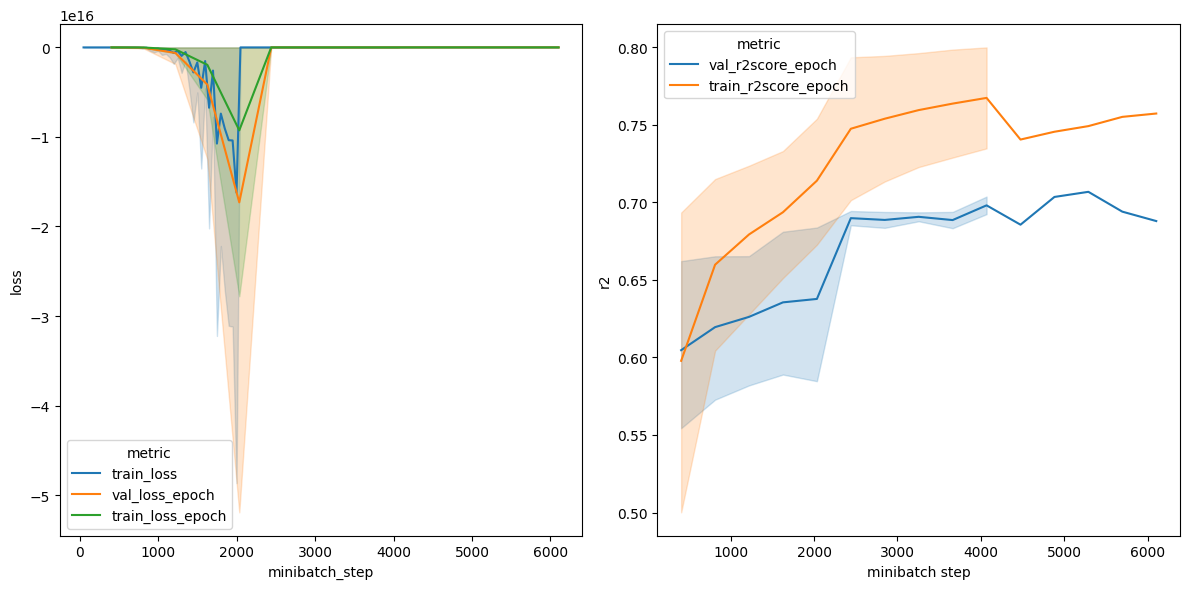

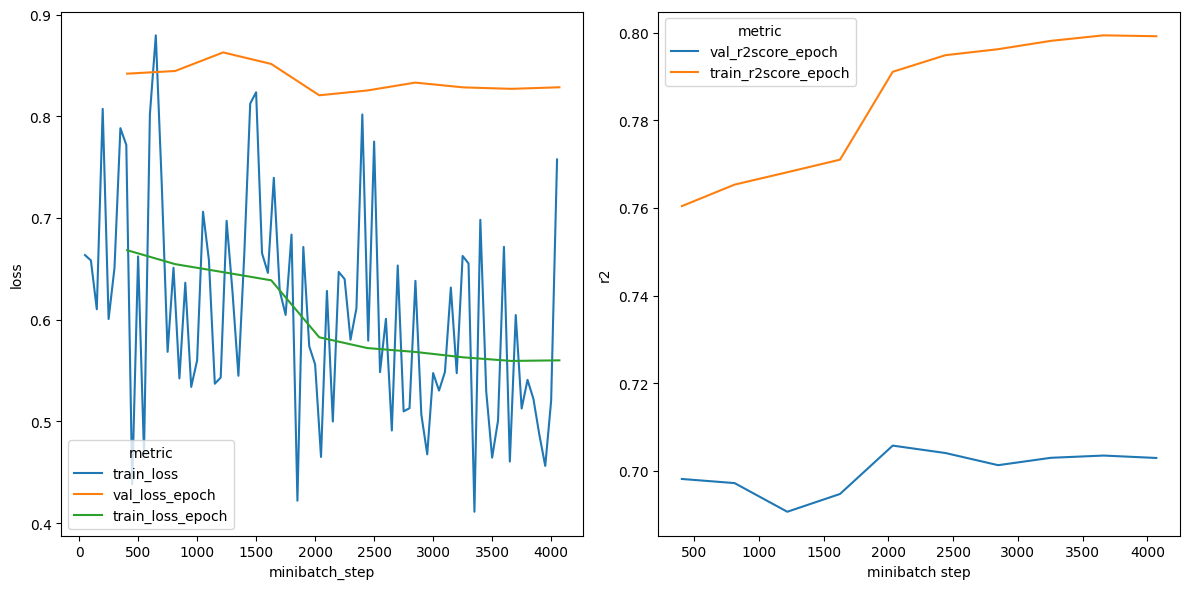

In [70]:
# Plot the Loss Function Results
from eugene import plot as pl

# Plot a loss curve and an r2 curve as a metric for my model
pl.training_summary(os.path.join(settings.logging_dir, "fritz_cnn", "tutorial_model"), metric="r2")

# Plot a loss curve and an r2 curve as a metric for the EUGENe CNN
pl.training_summary(os.path.join(settings.logging_dir, "cnn", "tutorial_model"), metric="r2")

Based on these two plots of the two CNN models, conclusions can be made about performance. Both models were run for 15 Epochs. Playing around with more variables like the epochs and some of the input/ouptput values of Fritz_CNN could privde more information and improve the overall model. Based on this information the conclusions I drew were as follows. Fritz_CNN function has a lower validation than the Eugene model throughout the training process, indicating that Fritz_CNN is generalizing better to unseen data and likely the better performing model. Eugene's CNN validation loss becomes lower over the epochs, suggesting that this model learned slower innitaly, but eventually generalized better, so more experiments with epochs would be helpful. Overall, both functions have similar validation losses, so if this was the only metric of performance, the differnces might not be very significant. Looking into more factors like training time, or model complexitity could show a better trade off and which is more computationaly expensive. Overall it was really cool using EUGENe's frame work to develop my own CNN model with 5 layers.